# Dacon AI Frienz Temperature Contest

### Score(mse) : 2.29041 ,  Leader Board : 21 / 972 teams

### 데이터 설명

-     대전지역에서 측정한 실내외 19곳의 센서데이터와, 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공합니다. 

-     센서는 온도를 측정하였습니다. 

-     모든 데이터는 시간 순으로 정렬 되어 있으며 10분 단위 데이터 입니다. 

-     예측 대상(target variable)은 Y18입니다. 



train.csv 

-     30일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y00~Y17)

-     이후 3일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y18)



test.csv 

-     train.csv 기간 이후 80일 간의 기상청 데이터 (X00~X39)



sample_submission.csv

-     제출 양식 예시

### 개발환경 

-     env : Google colab

-     Tensorflow/keras : 2.2.0

-     numpy : 1.18.2

-     pandas : 1.0.3 


## part1. Library / Data 

In [6]:
import pandas as pd
import pandas.util.testing as tm
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import os

import warnings
warnings.filterwarnings(action='ignore') 

import tensorflow as tf
import random
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from scipy.signal import savgol_filter

from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

C:\Users\Kim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


In [8]:
train = pd.read_csv('AIFrez_dataset/train.csv') #33days X00-X39,Y00-Y18
test = pd.read_csv('AIFrez_dataset/test.csv') #80days X00-X39

## part2. EDA

### 1) Feature EDA

In [9]:
#train data : 수치형 dataset

train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4752 entries, 0 to 4751
Data columns (total 60 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      4752 non-null   int64  
 1   X00     4752 non-null   float64
 2   X01     4752 non-null   float64
 3   X02     4752 non-null   float64
 4   X03     4752 non-null   float64
 5   X04     4752 non-null   float64
 6   X05     4752 non-null   float64
 7   X06     4752 non-null   float64
 8   X07     4752 non-null   float64
 9   X08     4752 non-null   float64
 10  X09     4752 non-null   float64
 11  X10     4752 non-null   float64
 12  X11     4752 non-null   float64
 13  X12     4752 non-null   float64
 14  X13     4752 non-null   float64
 15  X14     4752 non-null   float64
 16  X15     4752 non-null   float64
 17  X16     4752 non-null   float64
 18  X17     4752 non-null   float64
 19  X18     4752 non-null   float64
 20  X19     4752 non-null   float64
 21  X20     4752 non-null   float64
 22  

id          X00          X01          X02          X03  \
count  4752.00000  4752.000000  4752.000000  4752.000000  4752.000000   
mean   2375.50000    20.227904   988.621107     1.509764     1.453157   
std    1371.92857     4.707570     3.359916     1.071858     0.936151   
min       0.00000     8.300000   977.300000     0.000000     0.000000   
25%    1187.75000    16.900000   986.800000     0.700000     0.800000   
50%    2375.50000    19.900000   988.600000     1.300000     1.300000   
75%    3563.25000    24.100000   991.000000     2.100000     2.000000   
max    4751.00000    30.900000   997.200000    10.200000     5.800000   

               X04          X05          X06          X07          X08  ...  \
count  4752.000000  4752.000000  4752.000000  4752.000000  4752.000000  ...   
mean      1.270223  1008.333902   989.005093    21.658081  1008.790341  ...   
std       4.429852     3.395037     3.403714     4.377216     3.520317  ...   
min       0.000000   997.200000   978.100000    11.600000   997.300000  ...   
25%       0.000000  1006.500000   987.100000    18.400000  1006.700000  ...   
50%       0.000000  1008.500000   989.100000    21.200000  1008.800000  ...   
75%       0.000000  1010.800000   991.600000    24.825000  1011.400000  ...   
max      25.600000  1016.800000   997.400000    32.700000  1017.500000  ...   

               Y09          Y10          Y11          Y12          Y13  \
count  4320.000000  4320.000000  4320.000000  4320.000000  4320.000000   
mean     22.222801    23.737269    24.649653    23.641898    20.926157   
std       9.112299    10.599000    12.214870     8.400081     6.106031   
min       3.500000     4.000000     3.000000     6.000000     7.500000   
25%      15.500000    15.500000    15.000000    17.000000    16.500000   
50%      20.000000    20.500000    21.000000    22.000000    19.500000   
75%      30.500000    32.500000    34.500000    30.500000    25.000000   
max      42.000000    49.000000    53.000000    43.500000    38.000000   

               Y14          Y15          Y16          Y17         Y18  
count  4320.000000  4320.000000  4320.000000  4320.000000  432.000000  
mean     21.319444    21.564468    22.969097    23.381829   26.687500  
std       7.066149     6.810084     8.054272     9.275172    6.286621  
min       7.500000     7.000000     6.000000     7.000000   18.500000  
25%      16.500000    16.500000    16.500000    16.000000   21.000000  
50%      19.500000    20.000000    21.500000    20.000000   25.000000  
75%      25.000000    27.000000    30.000000    32.000000   31.500000  
max      42.500000    40.500000    41.500000    43.500000   41.500000  

[8 rows x 60 columns]

In [5]:
#X00~X39 : 기상 관측값들을 EDA를 위해, 그 관측 요소명에 맞게 나눠줌

temperature = ["X00","X07","X28","X31","X32"] #기온
local_atm = ["X01","X06","X22","X27","X29"] #현지기압
wind_speed      = ["X02","X03","X18","X24","X26"] #풍속
water       = ["X04","X10","X21","X36","X39"] #일일 누적강수량
sea_atm      = ["X05","X08","X09","X23","X33"] #해면기압
sun      = ["X11","X14","X16","X19","X34"] #일일 누적일사량
humidity   = ["X12","X20","X30","X37","X38"] #습도
wind_direction   = ["X13","X15","X17","X25","X35"] #풍향

## temperature 기온

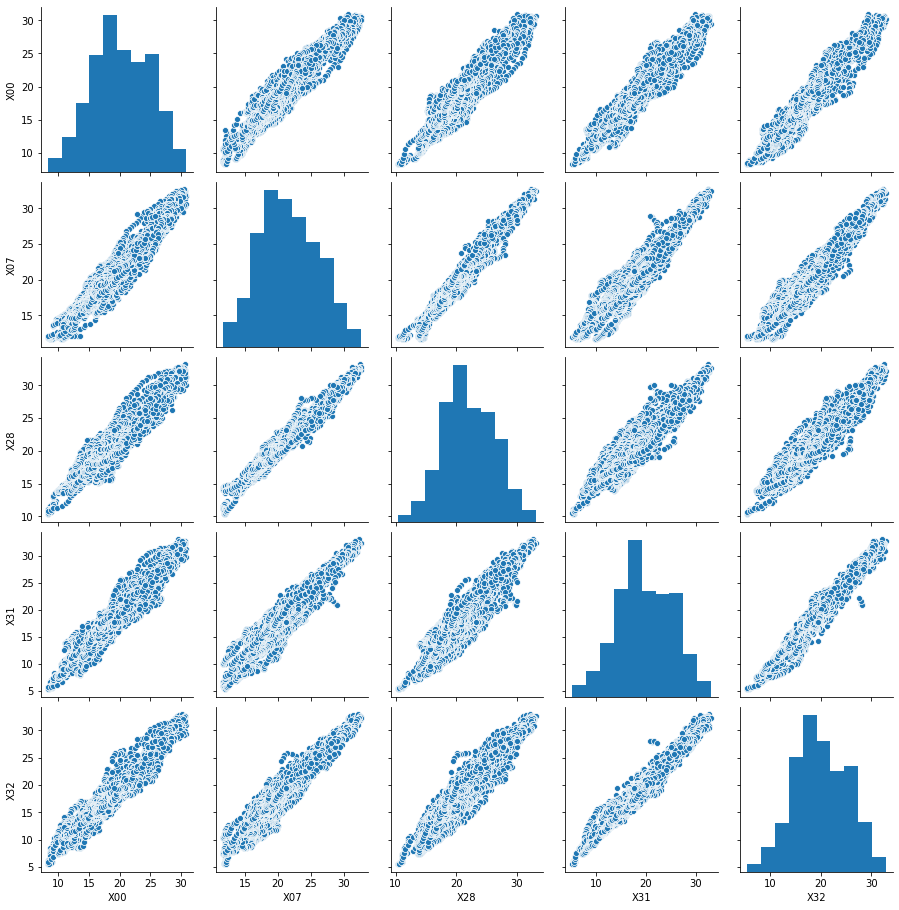

In [6]:
#기온
sns.pairplot(train[temperature])
plt.show()

X00          X07          X28          X31          X32
count  4752.000000  4752.000000  4752.000000  4752.000000  4752.000000
mean     20.227904    21.658081    22.079040    19.846528    20.012984
std       4.707570     4.377216     4.225203     5.520259     5.271630
min       8.300000    11.600000    10.300000     5.300000     5.500000
25%      16.900000    18.400000    19.000000    16.000000    16.300000
50%      19.900000    21.200000    21.700000    19.400000    19.600000
75%      24.100000    24.825000    25.200000    24.100000    24.100000
max      30.900000    32.700000    33.200000    33.100000    32.900000

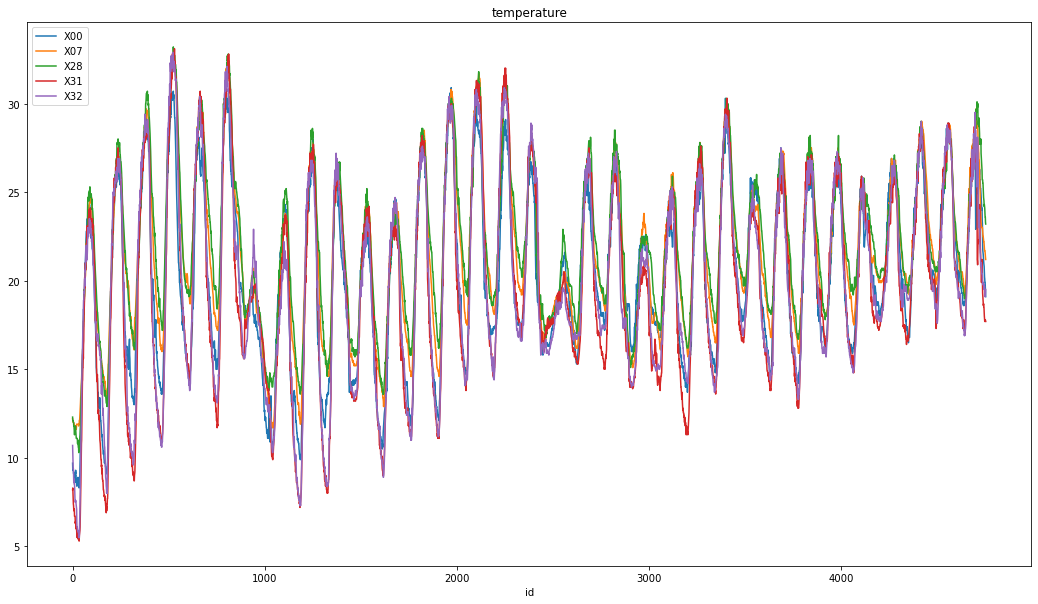

In [7]:
#기온
train.plot(x="id",  y=temperature, figsize=(18,10), title="temperature")
train[temperature].describe()

## local atm 현지기압

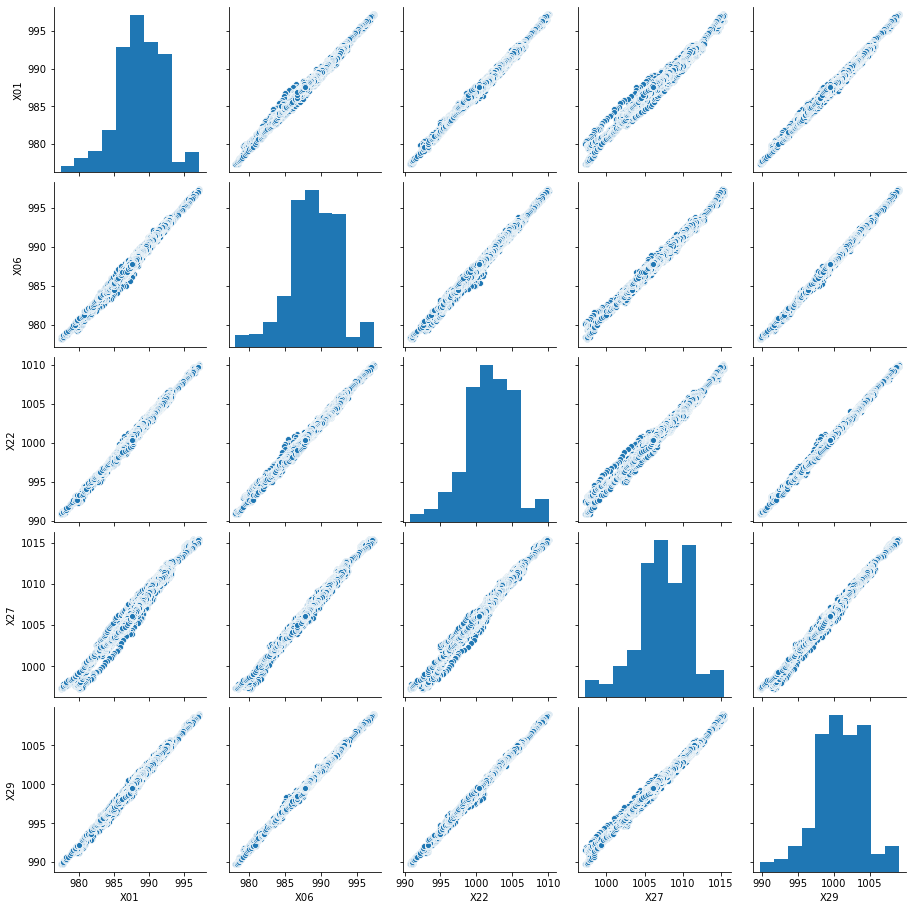

In [8]:
#현지기압
sns.pairplot(train[local_atm])
plt.show()

X01          X06          X22          X27          X29
count  4752.000000  4752.000000  4752.000000  4752.000000  4752.000000
mean    988.621107   989.005093  1001.773190  1007.554924  1000.811932
std       3.359916     3.403714     3.367735     3.446475     3.390206
min     977.300000   978.100000   990.800000   997.200000   989.700000
25%     986.800000   987.100000   999.900000  1005.500000   998.900000
50%     988.600000   989.100000  1001.900000  1007.700000  1000.900000
75%     991.000000   991.600000  1004.200000  1010.200000  1003.400000
max     997.200000   997.400000  1010.100000  1015.400000  1009.000000

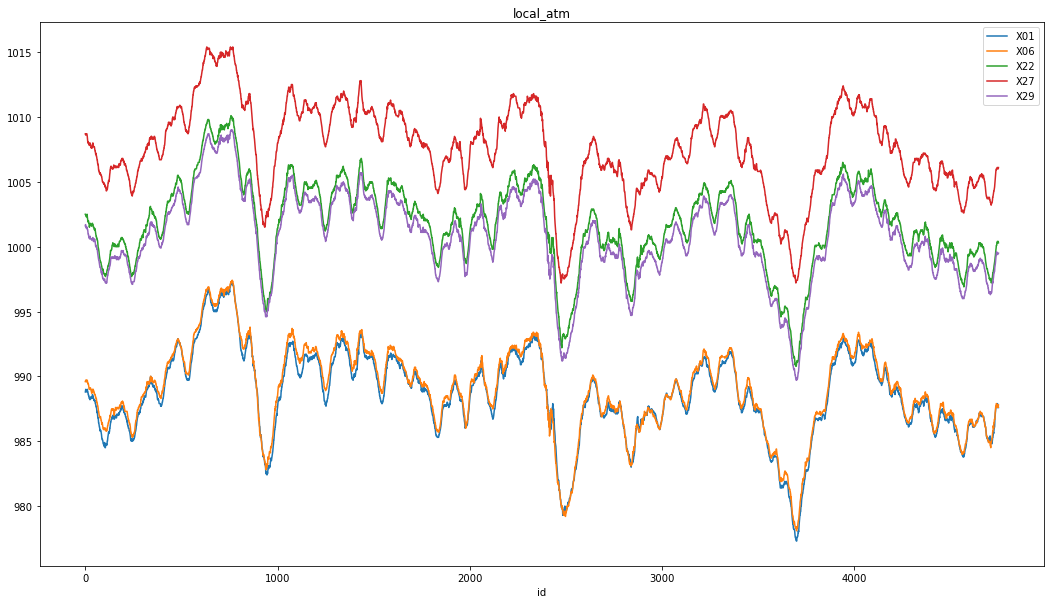

In [9]:
#기온
train.plot(x="id",  y=local_atm, figsize=(18,10), title="local_atm")
train[local_atm].describe()

## WindSpeed 풍속

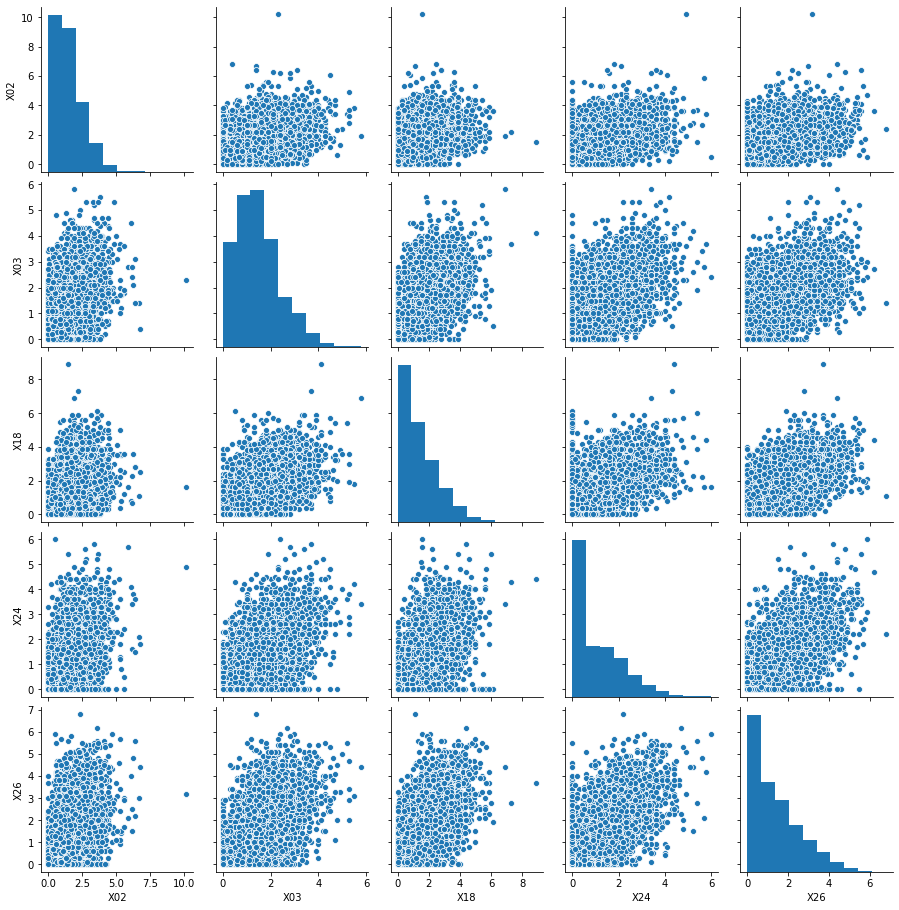

In [10]:
#풍속에서 이상치 발견
sns.pairplot(train[wind_speed])
plt.show()

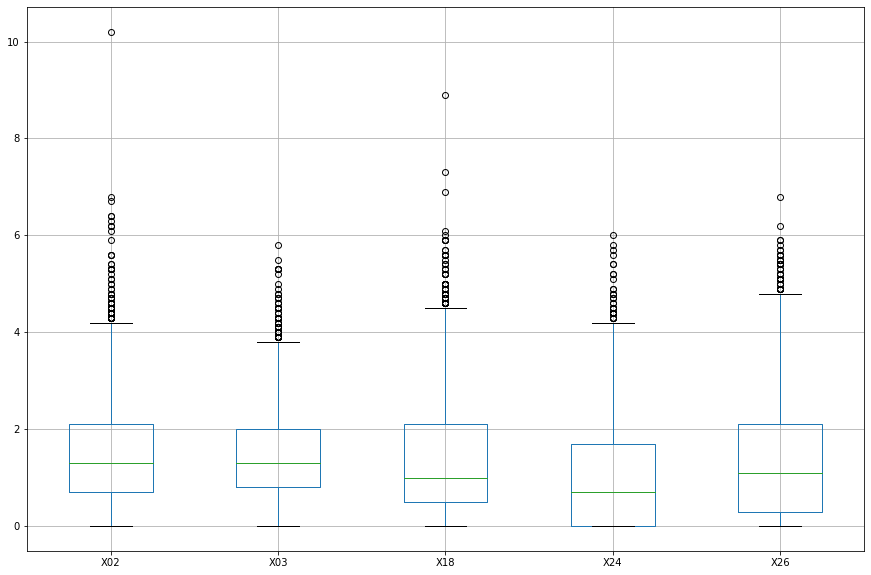

In [11]:
train[wind_speed].boxplot(figsize=(15,10))

X02          X03          X18          X24          X26
count  4752.000000  4752.000000  4752.000000  4752.000000  4752.000000
mean      1.509764     1.453157     1.377462     0.985059     1.369886
std       1.071858     0.936151     1.155024     1.091314     1.240900
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       0.700000     0.800000     0.500000     0.000000     0.300000
50%       1.300000     1.300000     1.000000     0.700000     1.100000
75%       2.100000     2.000000     2.100000     1.700000     2.100000
max      10.200000     5.800000     8.900000     6.000000     6.800000

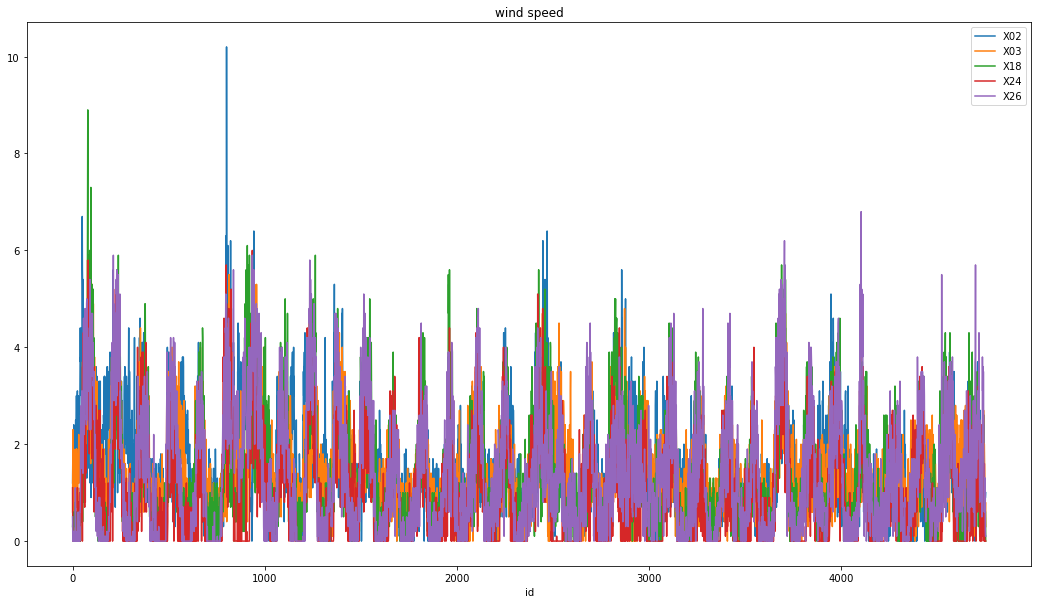

In [12]:
#풍속
train.plot(x="id",  y=wind_speed, figsize=(18,10), title="wind speed")
train[wind_speed].describe()

In [13]:
train[train["X02"]==10.2]

id   X00    X01   X02  X03  X04     X05    X06   X07     X08  ...   Y09  \
801  801  30.6  993.4  10.2  2.3  0.0  1012.9  993.4  31.9  1012.3  ...  40.5   

      Y10   Y11   Y12   Y13   Y14   Y15   Y16   Y17  Y18  
801  47.5  51.5  36.0  37.0  37.0  40.0  38.5  40.0  NaN  

[1 rows x 60 columns]

In [14]:
#이상치 처리 : 같은 시간때의 풍속 센서들의 평균으로 대체 # 이상치가 많은것을 확인 => 어떻기 처리??

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))
outliers_iqr(train[wind_speed])

(array([  40,   48,   49,   50,   51,   52,   54,   55,   55,   57,   58,
          61,   65,   67,   70,   72,   72,   72,   73,   74,   77,   77,
          78,   78,   78,   79,   79,   81,   81,   82,   83,   86,   86,
          87,   89,   89,   90,   90,   91,   91,   92,   93,   93,   94,
          95,   95,   96,   97,   97,   98,   98,  100,  100,  101,  102,
         103,  107,  108,  211,  212,  212,  214,  214,  215,  216,  219,
         220,  222,  223,  223,  223,  225,  226,  227,  228,  229,  230,
         231,  233,  233,  233,  234,  236,  236,  237,  238,  239,  244,
         246,  292,  351,  352,  353,  370,  376,  377,  378,  676,  788,
         792,  794,  795,  796,  797,  798,  798,  799,  799,  800,  801,
         801,  802,  802,  805,  808,  808,  810,  810,  811,  811,  811,
         812,  813,  814,  818,  819,  820,  822,  825,  826,  837,  861,
         864,  896,  897,  898,  899,  902,  903,  904,  906,  909,  911,
         917,  918,  920,  921,  922, 

In [15]:
train.loc[801:801,"X02"]=train.loc[801:801,wind_speed].mean(axis=1)

## Water 강수량

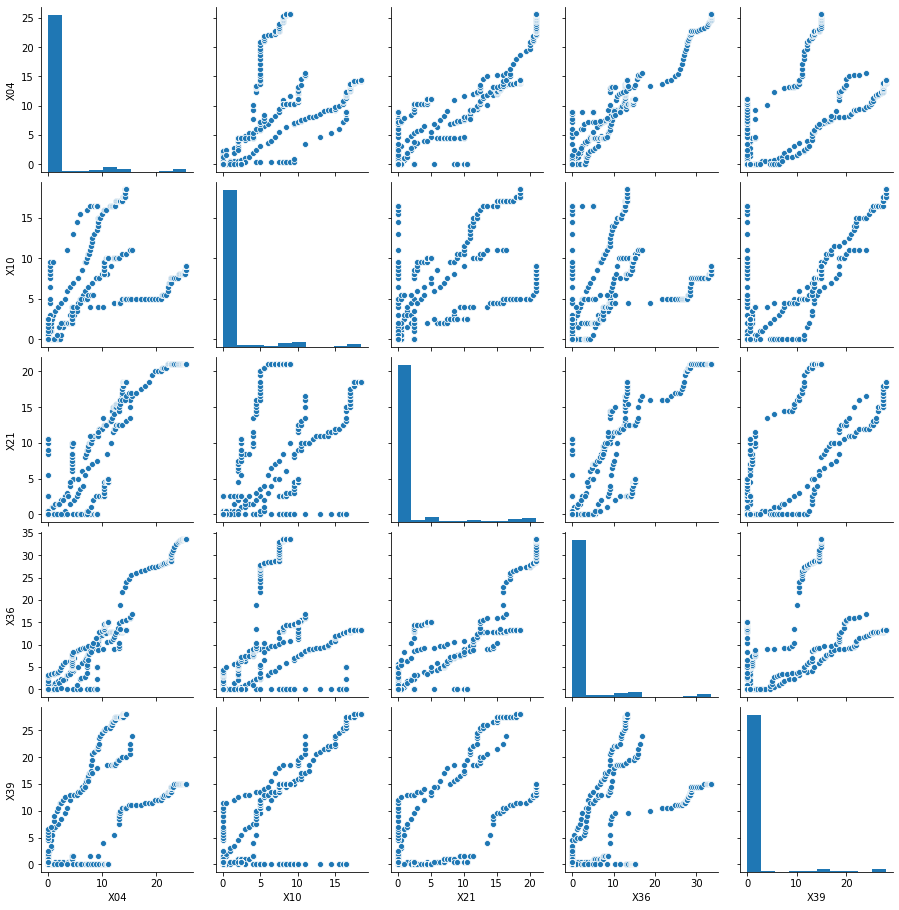

In [16]:
sns.pairplot(train[water])
plt.show()

X04          X10          X21          X36          X39
count  4752.000000  4752.000000  4752.000000  4752.000000  4752.000000
mean      1.270223     1.006734     1.138363     1.533817     1.083123
std       4.429852     3.324415     4.079039     5.578607     4.617366
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000     0.000000     0.000000
75%       0.000000     0.000000     0.000000     0.000000     0.000000
max      25.600000    18.500000    21.000000    33.600000    28.000000

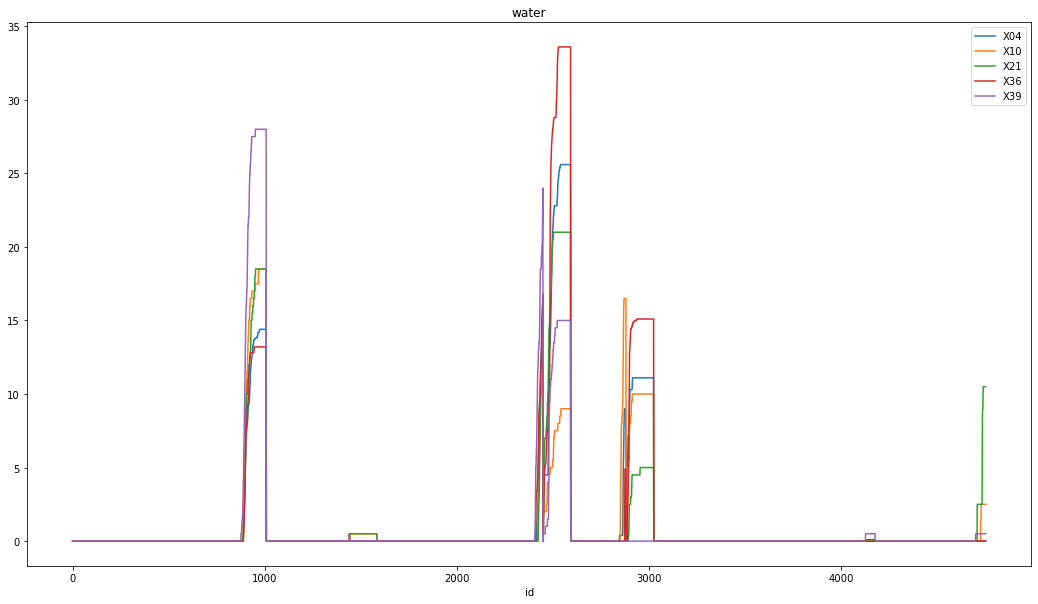

In [17]:
train.plot(x="id",  y=water, figsize=(18,10), title="water")
train[water].describe()

##  해면기압

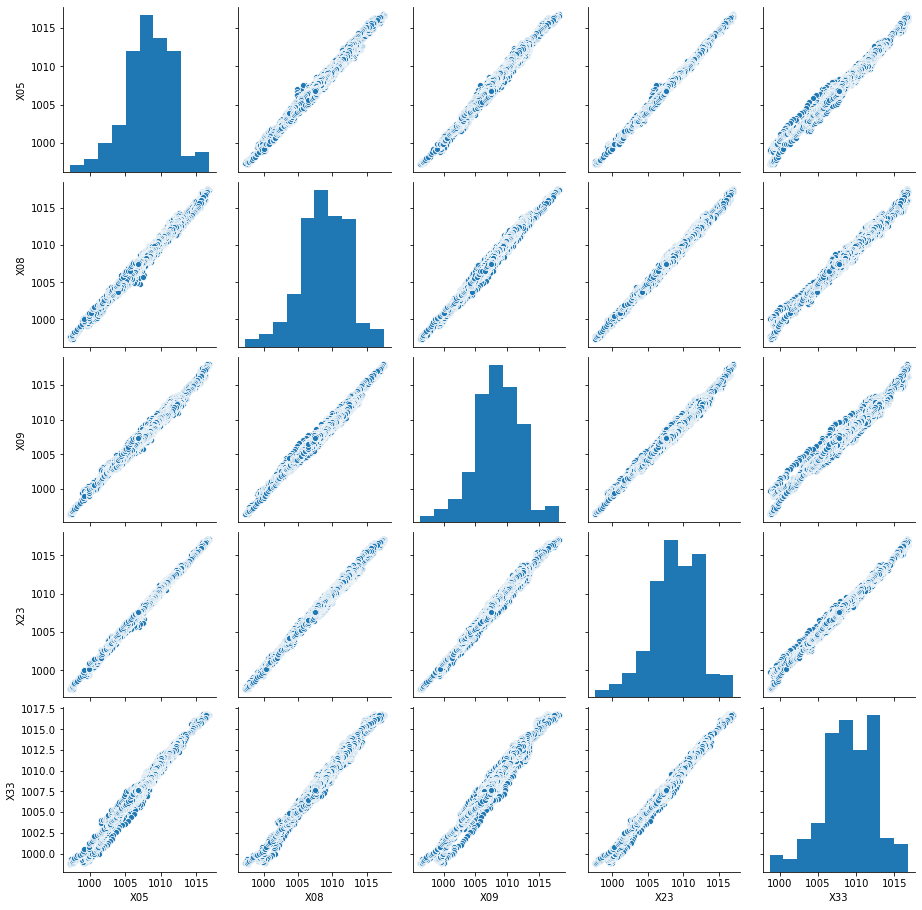

In [20]:
sns.pairplot(train[sea_atm])
plt.show()

X05          X08          X09          X23          X33
count  4752.000000  4752.000000  4752.000000  4752.000000  4752.000000
mean   1008.333902  1008.790341  1008.394171  1008.850989  1009.074747
std       3.395037     3.520317     3.546180     3.417633     3.440669
min     997.200000   997.300000   996.300000   997.500000   998.700000
25%    1006.500000  1006.700000  1006.300000  1006.900000  1007.075000
50%    1008.500000  1008.800000  1008.400000  1008.900000  1009.200000
75%    1010.800000  1011.400000  1010.900000  1011.400000  1011.700000
max    1016.800000  1017.500000  1018.000000  1017.100000  1016.800000

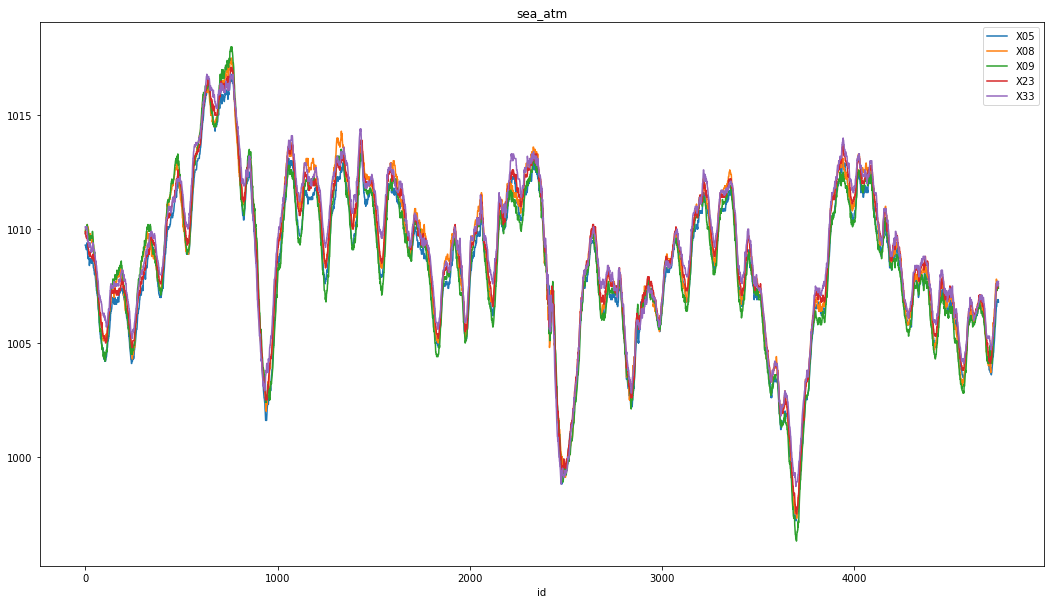

In [21]:
train.plot(x="id",  y=sea_atm, figsize=(18,10), title="sea_atm")
train[sea_atm].describe() #5개 변수 모두 동일 

## 누적 일일 일사량 Sun

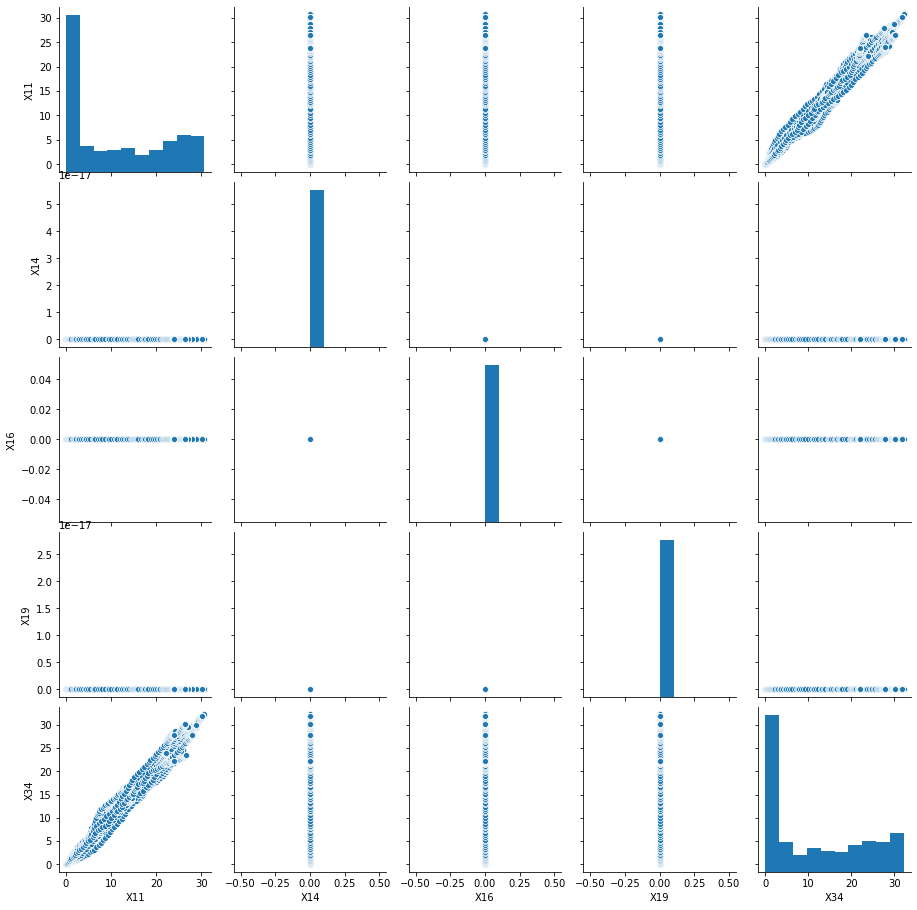

In [22]:
sns.pairplot(train[sun])
plt.show() #X14,X16,X19제거

X11     X14     X16     X19          X34
count  4752.000000  4752.0  4752.0  4752.0  4752.000000
mean     11.008479     0.0     0.0     0.0    11.567563
std      10.873539     0.0     0.0     0.0    11.386727
min       0.000000     0.0     0.0     0.0     0.000000
25%       0.020000     0.0     0.0     0.0     0.030000
50%       7.690000     0.0     0.0     0.0     8.210000
75%      22.190000     0.0     0.0     0.0    22.562500
max      30.700000     0.0     0.0     0.0    32.240000

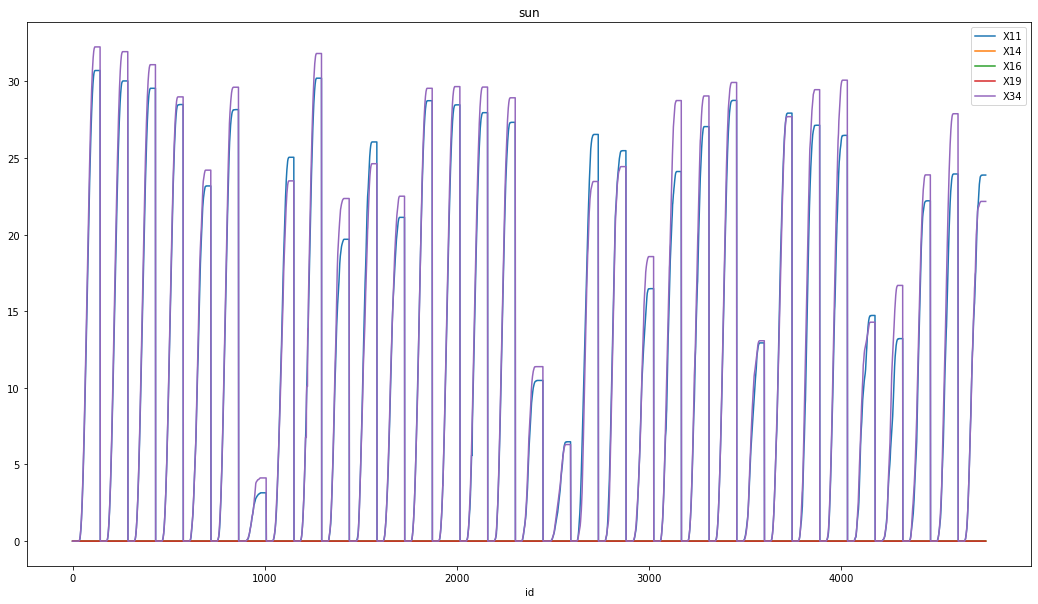

In [23]:
train.plot(x="id",  y=sun, figsize=(18,10), title="sun")
train[sun].describe()

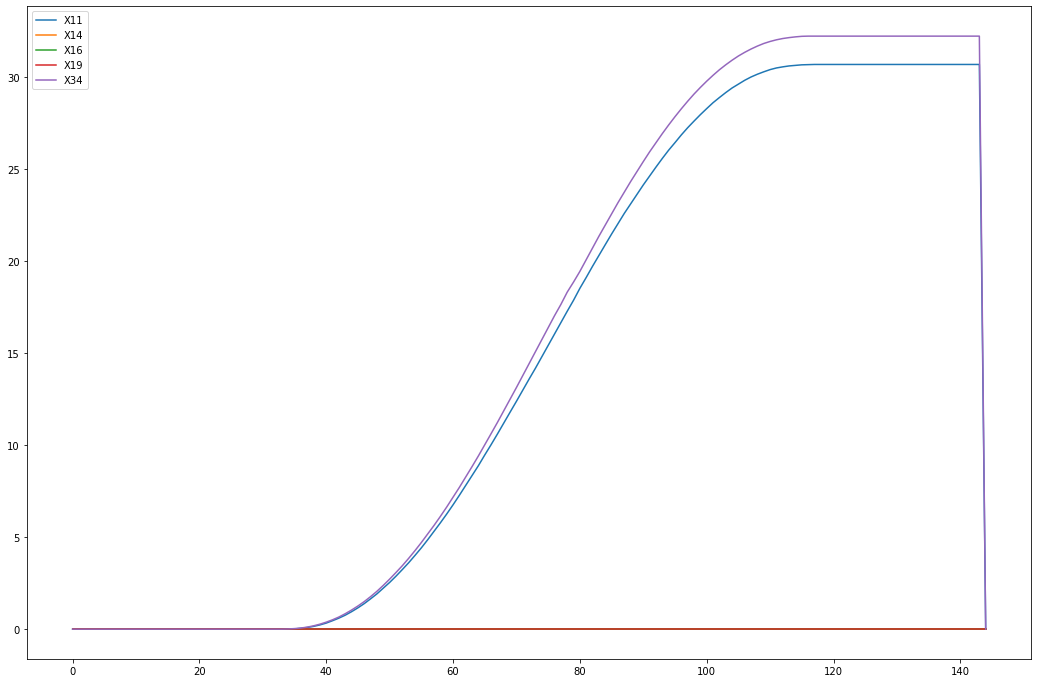

In [24]:
#누적 일사량은 하루마다 리셋. 즉, 시작은 00시 부터 시작. #일일 강수량도 마찬가지.
train[sun].loc[:144,:].plot(figsize=(18,12))

## 습도 

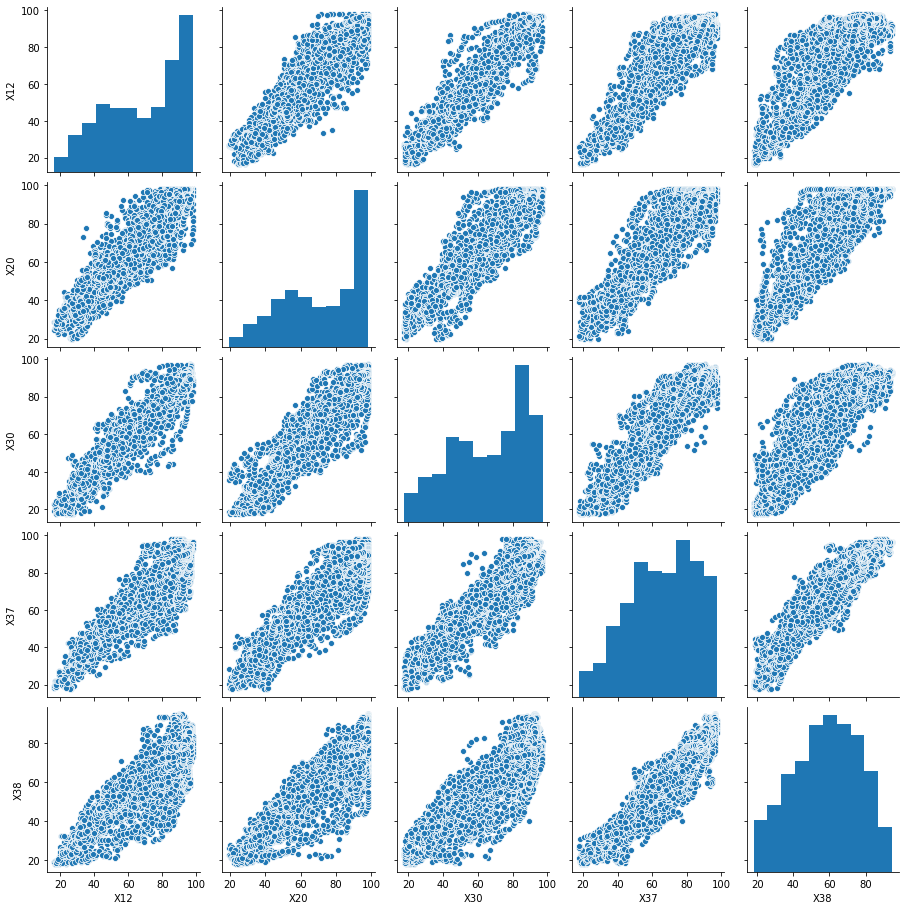

In [25]:
#습도
sns.pairplot(train[humidity])
plt.show() 

## 풍향

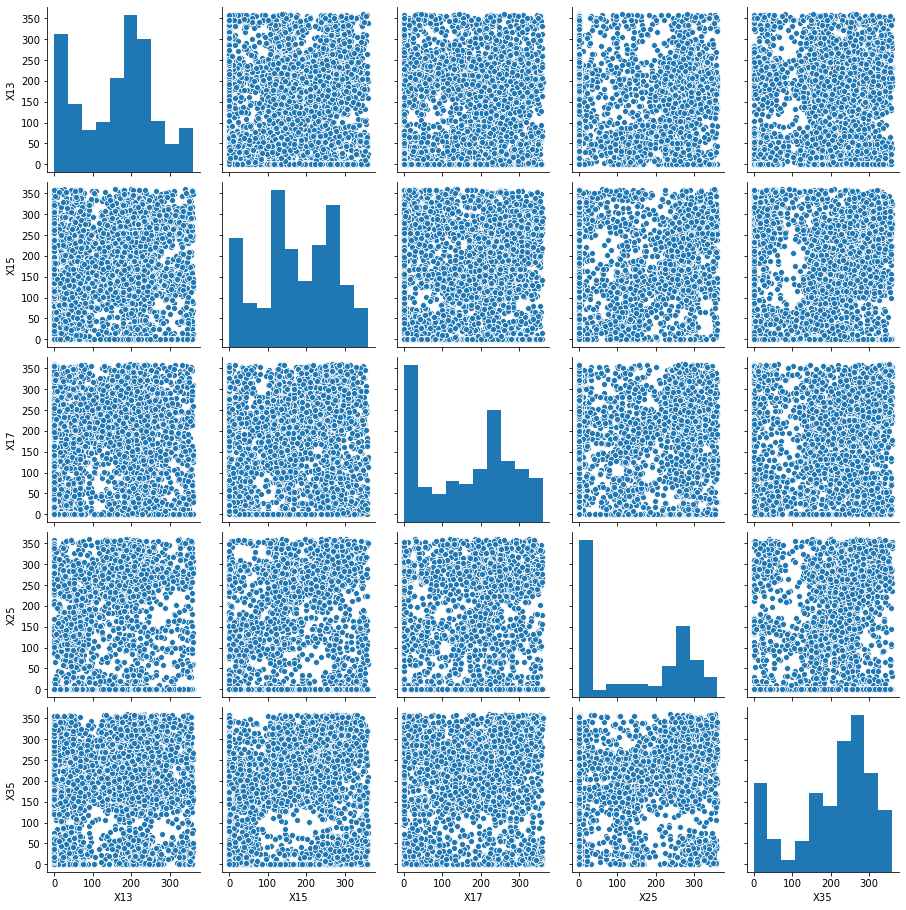

In [26]:
sns.pairplot(train[wind_direction])
plt.show() 

X13          X15          X17          X25          X35
count  4752.000000  4752.000000  4752.000000  4752.000000  4752.000000
mean    161.357639   174.346654   161.823864   139.524453   208.400505
std      98.787460    97.785811   115.943382   131.438036    99.580562
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%      69.225000   115.600000    33.875000     0.000000   155.300000
50%     182.600000   170.250000   190.450000   134.150000   240.850000
75%     228.925000   258.400000   253.125000   270.900000   277.800000
max     360.000000   359.900000   360.000000   359.900000   359.900000

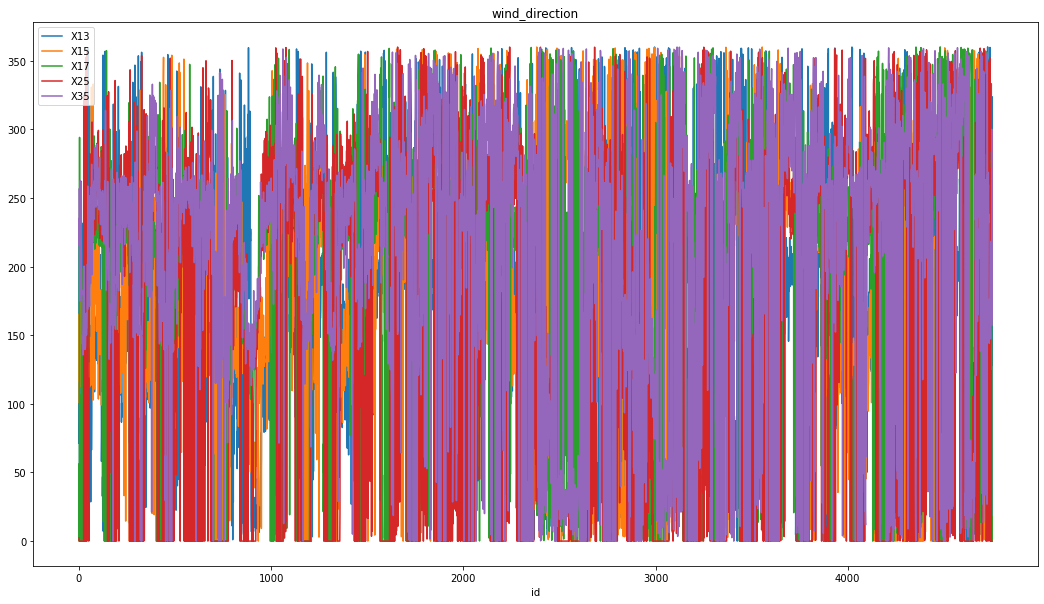

In [27]:
train.plot(x="id",  y=wind_direction, figsize=(18,10), title="wind_direction")
train[wind_direction].describe()

### 2) Y18과 가장 상관관계 높은 Y센서 찾기

#### 하지만, Y00-Y17 센서값들과 Y18이 같은 시점에 없기(NaN : Y00-Y17(30-33days), Y18(~30days))때문에 서로 가장 가까운 시점으로 찾아 보기로 함.

In [10]:
#Y18이 Not Null인 3일간의 data

train[~train["Y18"].isnull()]["Y18"] #432행 #3일(1일:144행)

4320    20.5
4321    20.5
4322    20.5
4323    20.5
4324    20.5
        ... 
4747    21.5
4748    21.5
4749    21.5
4750    21.5
4751    21.0
Name: Y18, Length: 432, dtype: float64

In [11]:
y18= train[~train["Y18"].isnull()]["Y18"].reset_index(drop=True)

In [12]:
not_y18_target=['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08','Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17']

In [13]:
#Y18과 비교를 위해 Y1~17를 Y18과 최소 근접한 시간대로 맞춰 df 설정.

not_y18 = train[(train['Y18'].isnull()) & (train["id"]>3887)][not_y18_target].reset_index(drop = True)
not_y18

Y00   Y01   Y02   Y03   Y04   Y05   Y06   Y07   Y08   Y09   Y10   Y11  \
0    20.5  20.5  20.5  25.5  25.5  19.5  18.5  19.0  19.5  17.5  18.5  17.5   
1    20.0  20.5  20.5  25.5  25.5  19.5  18.5  19.0  19.5  17.0  18.0  17.5   
2    20.0  20.0  20.5  25.5  25.5  19.5  18.0  19.0  19.0  17.0  18.0  17.0   
3    20.0  20.0  20.0  25.5  25.0  19.5  18.0  19.0  19.0  17.0  18.0  17.0   
4    19.5  20.0  20.0  25.0  25.0  19.5  18.0  18.5  19.0  17.0  17.5  17.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
427  22.0  22.5  22.5  26.0  26.0  21.0  20.0  20.5  20.5  19.5  20.0  19.0   
428  22.0  22.5  22.5  26.0  25.5  21.0  20.0  20.5  20.5  19.5  20.0  19.0   
429  21.5  22.5  22.5  26.0  25.5  21.0  20.0  20.5  20.5  19.5  20.0  19.0   
430  21.5  22.0  22.0  25.5  25.5  20.5  20.0  20.0  20.0  19.5  20.0  18.5   
431  21.5  22.0  22.0  25.5  25.5  20.5  19.5  20.0  20.0  19.5  20.0  18.5   

      Y12   Y13   Y14   Y15   Y16   Y17  
0    18.5  18.0  17.5  17.0  18.5  17.0  
1    18.5  17.5  17.5  17.0  18.0  17.0  
2    18.5  17.5  17.5  17.0  18.0  17.0  
3    18.5  17.0  17.0  17.0  18.0  16.5  
4    18.0  17.0  17.0  17.0  18.0  16.5  
..    ...   ...   ...   ...   ...   ...  
427  20.5  20.5  20.0  20.0  20.5  20.0  
428  20.5  20.5  20.0  19.5  20.5  19.5  
429  20.0  20.0  19.5  19.5  20.0  19.0  
430  20.0  20.0  19.5  19.5  20.0  19.0  
431  19.5  19.5  19.5  19.5  19.5  19.0  

[432 rows x 18 columns]

In [14]:
check_target=pd.concat([not_y18,y18], axis=1)

In [15]:
check_target.head()

Y00   Y01   Y02   Y03   Y04   Y05   Y06   Y07   Y08   Y09   Y10   Y11  \
0  20.5  20.5  20.5  25.5  25.5  19.5  18.5  19.0  19.5  17.5  18.5  17.5   
1  20.0  20.5  20.5  25.5  25.5  19.5  18.5  19.0  19.5  17.0  18.0  17.5   
2  20.0  20.0  20.5  25.5  25.5  19.5  18.0  19.0  19.0  17.0  18.0  17.0   
3  20.0  20.0  20.0  25.5  25.0  19.5  18.0  19.0  19.0  17.0  18.0  17.0   
4  19.5  20.0  20.0  25.0  25.0  19.5  18.0  18.5  19.0  17.0  17.5  17.0   

    Y12   Y13   Y14   Y15   Y16   Y17   Y18  
0  18.5  18.0  17.5  17.0  18.5  17.0  20.5  
1  18.5  17.5  17.5  17.0  18.0  17.0  20.5  
2  18.5  17.5  17.5  17.0  18.0  17.0  20.5  
3  18.5  17.0  17.0  17.0  18.0  16.5  20.5  
4  18.0  17.0  17.0  17.0  18.0  16.5  20.5

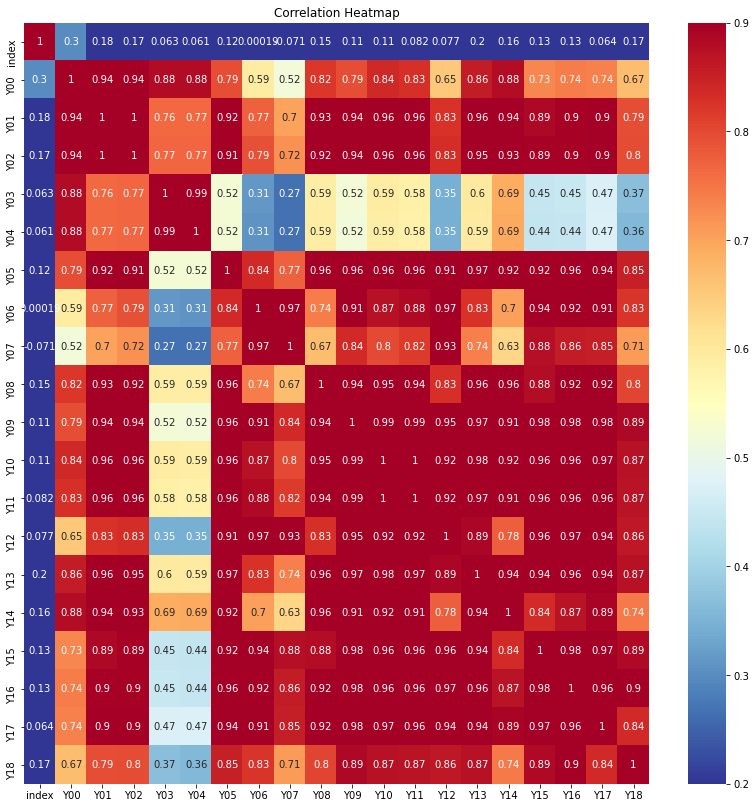

In [19]:
correlation=check_target.corr()
plt.figure(figsize=(14,14))

sns.heatmap(correlation, cmap=plt.cm.RdYlBu_r,  vmin = 0.2, annot = True, vmax = 0.9)
plt.title('Correlation Heatmap'); #Y18과 가장 상관관계 높은 Y16,Y15,Y09,Y11,Y13,,

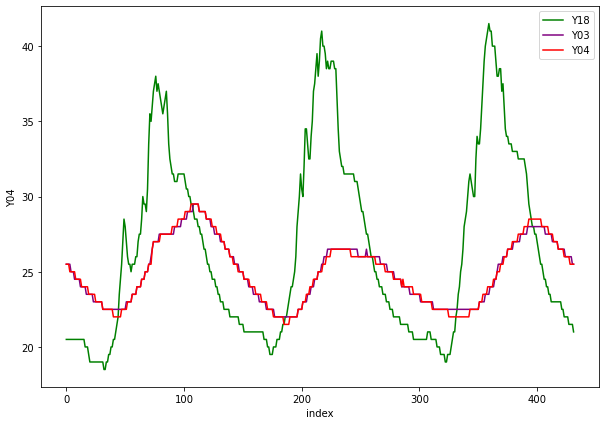

In [17]:
#cor가 가장 낮은 Y3,Y4 와 Y18과의 시각화

check_target.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(data=check_target, x='index', y='Y18', color='green', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y03', color='purple', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y04', color='red', ax=ax)
plt.legend(['Y18', 'Y03', 'Y04'])
plt.show()

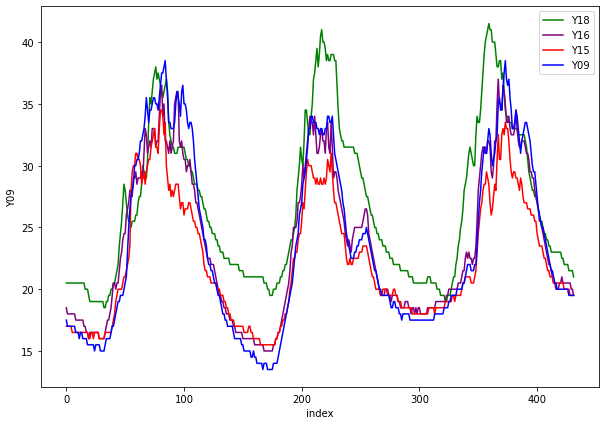

In [18]:
#cor가 가장 가장 높은 상위 3개 Y09,Y14,Y15 와 Y18과의 시각화

fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(data=check_target, x='index', y='Y18', color='green', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y16', color='purple', ax=ax) #0.903224
sns.lineplot(data=check_target, x='index', y='Y15', color='red', ax=ax) #0.885760
sns.lineplot(data=check_target, x='index', y='Y09', color='blue', ax=ax) #0.886783 
plt.legend(['Y18', 'Y16', 'Y15', "Y09"])
plt.show()

## Part 3 . Data Cleaning & Pre-Processing 

#### 일조량 X14, X16. X19가 모두 0인것을 발견했으나, 영향을 줄수 있다고 생각을 해서 모델에 넣어보고 처리해 주기로 결정. 

#### 일단 별도의 전처리를 하지 않고 진행하기로 결정. 

## [전반적인 EDA를 통한 데이터 설계] 

#### 1. 강수량, 일조량은 일일 누적량

-     reset시점이 00가 되기때문에 데이터 시간 흐름이 00시 부터 시작.

-     강수량, 일조량 각각 전 시점과의 차이(diff)로 실제 증가량 columns만들기.

#### 2. 깊은 학습을 위해 온도, 습도, 풍속 등과같은 기후 관련 공식을 이용해 새로운 Features 더 생성.

#### 3. 풍속같은 Feature에 많은 이상치 확인. 그 외 일조량 Feature들도 전처리를 해줘야 할지는 추후 모델에 넣어보고 결정하기로 함.

#### 4. 예측 진행 : 30days-33days에 비어있는 3일치 Y00-Y17 예측 ->  ~30days에 비어있는 30일치 Y18 예측 ->  80days(test) 의 Y18 예측

#### 5. 모델 : float형, 시계열 data이며 예측 문제이며, 모든 피쳐를 모두 사용하는 LSTM (rnn model) 혹은 MLP (deep neuralnet model) 이 적합하다고 판단.

## part 4. Feature Engineering

### 1) 온도 / 습도 같은 지점 연결

#### 연결을 시켜주어야 하는 이유는 온도, 습도 컬럼을 통해 온습도가 포함된 공식으로 새 Feature를 추가해주어야 하기 때문
#### 상관관계와 그래프 계형을 보며 같은 지점끼리의 온도와 습도 센서 데이터를 찾았다.
#### 눈으로 판별이 조금 헷갈린 부분은 시계열 분해를 통해 찾을 수 있었다. 

In [28]:
pd.merge(train[temperature],train[humidity], left_index=True, right_index=True).corr()

X00       X07       X28       X31       X32       X12       X20  \
X00  1.000000  0.957922  0.941699  0.961053  0.963055 -0.792650 -0.819854   
X07  0.957922  1.000000  0.981081  0.954865  0.962826 -0.804570 -0.802256   
X28  0.941699  0.981081  1.000000  0.935156  0.938572 -0.785810 -0.794099   
X31  0.961053  0.954865  0.935156  1.000000  0.979312 -0.819450 -0.794248   
X32  0.963055  0.962826  0.938572  0.979312  1.000000 -0.806271 -0.797586   
X12 -0.792650 -0.804570 -0.785810 -0.819450 -0.806271  1.000000  0.937239   
X20 -0.819854 -0.802256 -0.794099 -0.794248 -0.797586  0.937239  1.000000   
X30 -0.760738 -0.787334 -0.764168 -0.775408 -0.800829  0.952855  0.928021   
X37 -0.680524 -0.755437 -0.750006 -0.681817 -0.690788  0.908078  0.900590   
X38 -0.605612 -0.670882 -0.705420 -0.583497 -0.596864  0.853899  0.855513   

          X30       X37       X38  
X00 -0.760738 -0.680524 -0.605612  
X07 -0.787334 -0.755437 -0.670882  
X28 -0.764168 -0.750006 -0.705420  
X31 -0.775408 -0.681817 -0.583497  
X32 -0.800829 -0.690788 -0.596864  
X12  0.952855  0.908078  0.853899  
X20  0.928021  0.900590  0.855513  
X30  1.000000  0.921706  0.851052  
X37  0.921706  1.000000  0.931389  
X38  0.851052  0.931389  1.000000

####  시계열 분해

<Figure size 432x288 with 0 Axes>

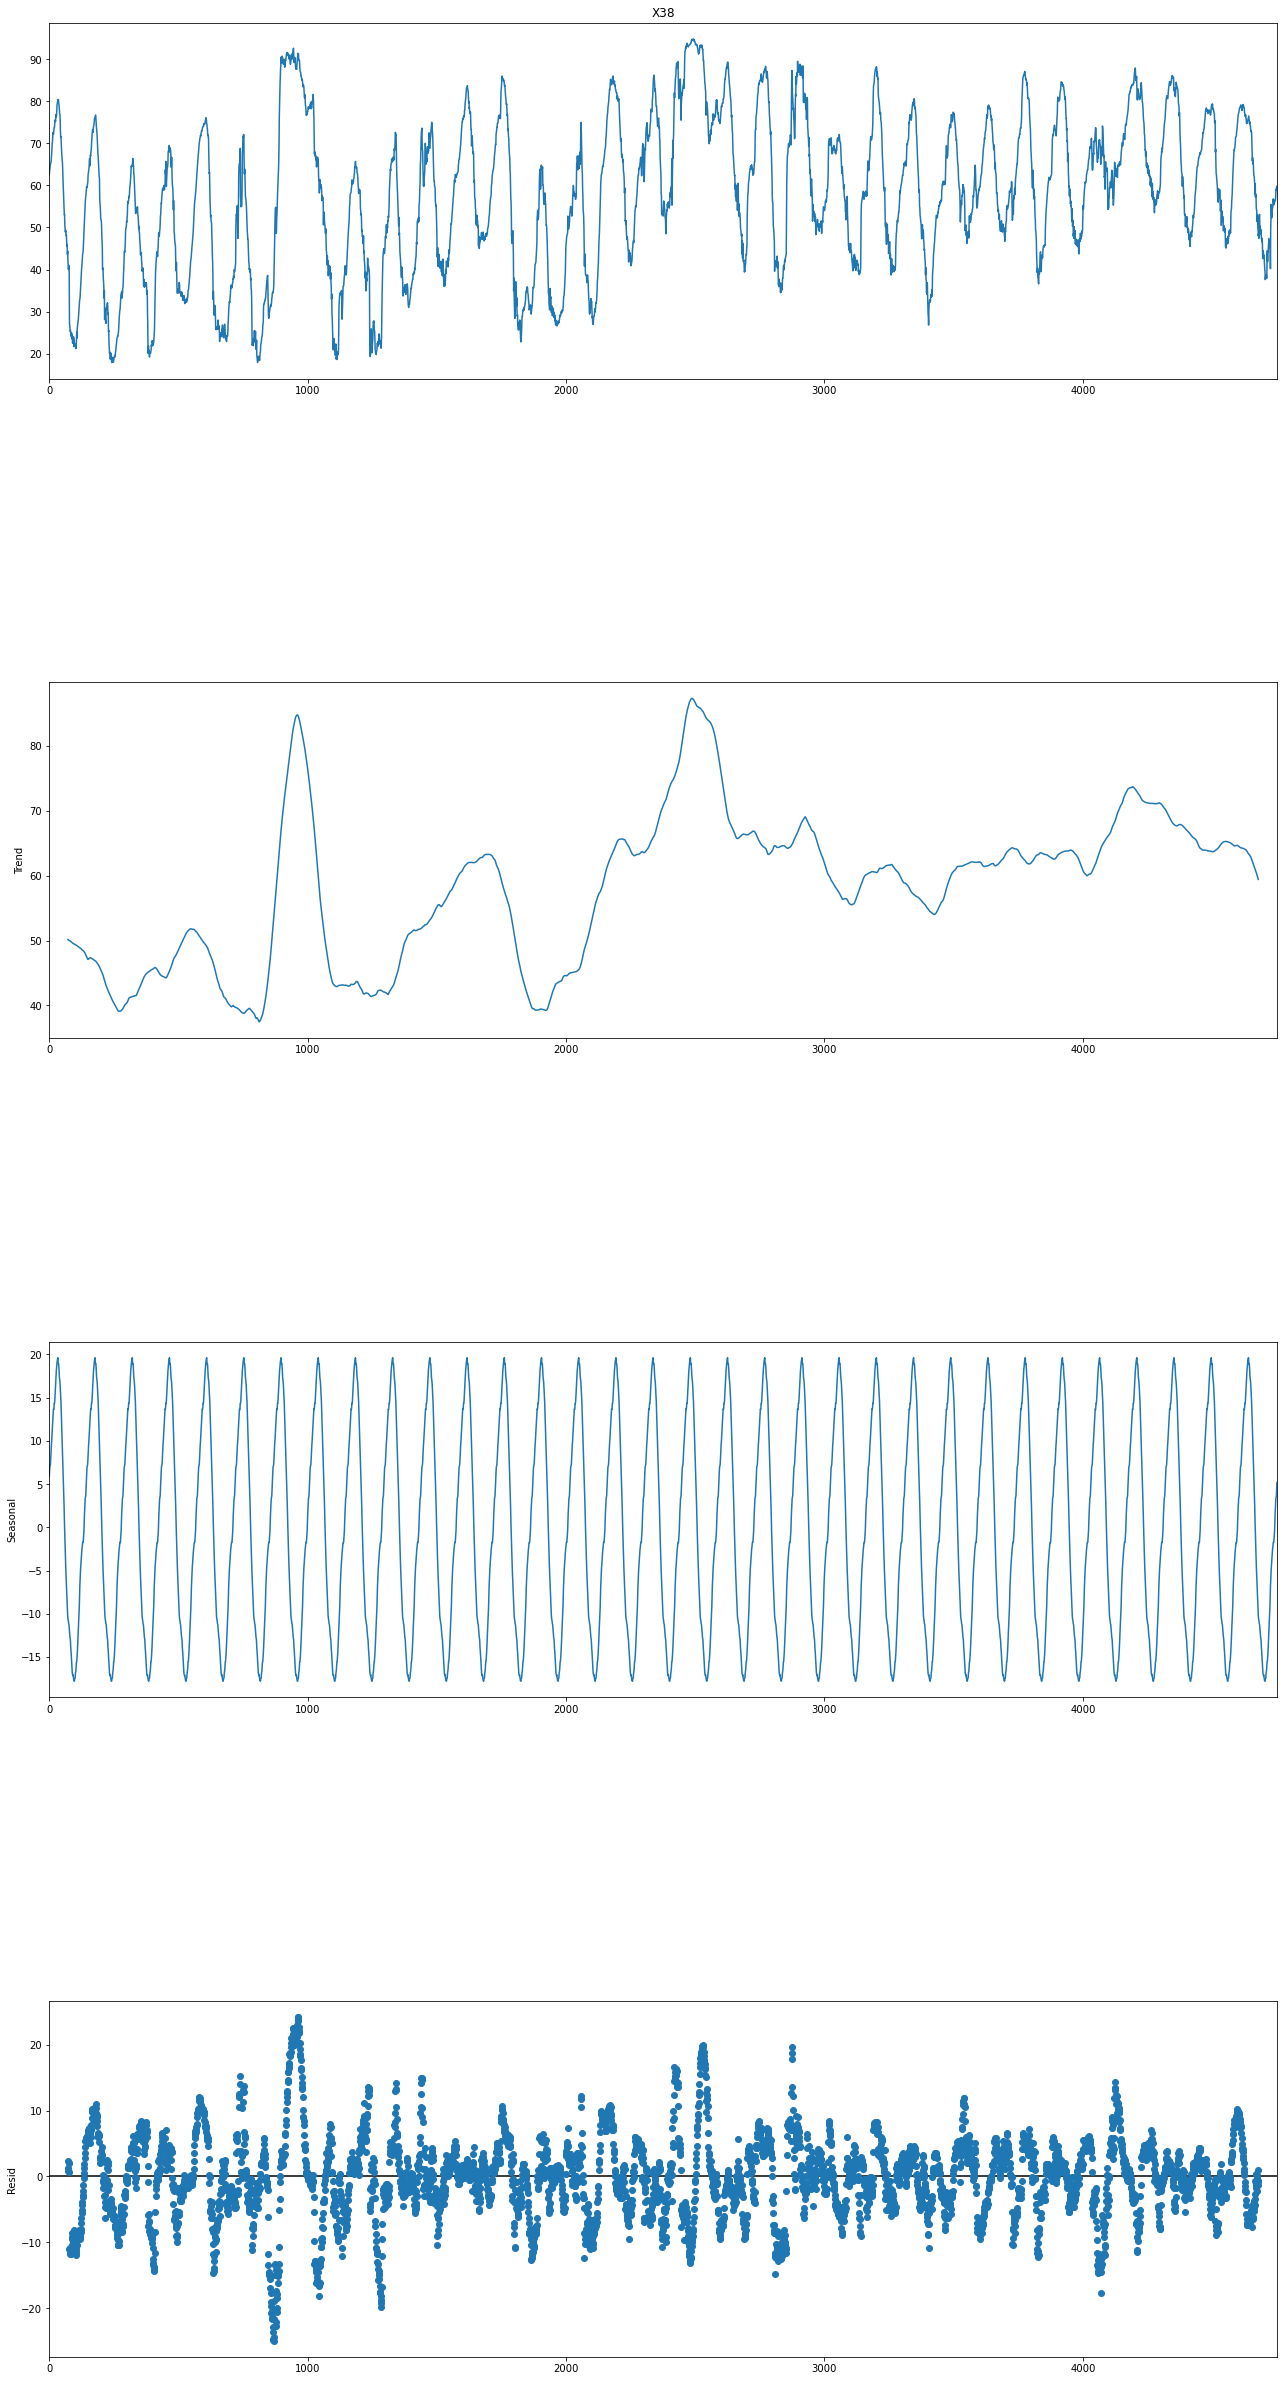

In [21]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train["X38"], model = 'addictive', freq = 144) #
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,40)

<Figure size 432x288 with 0 Axes>

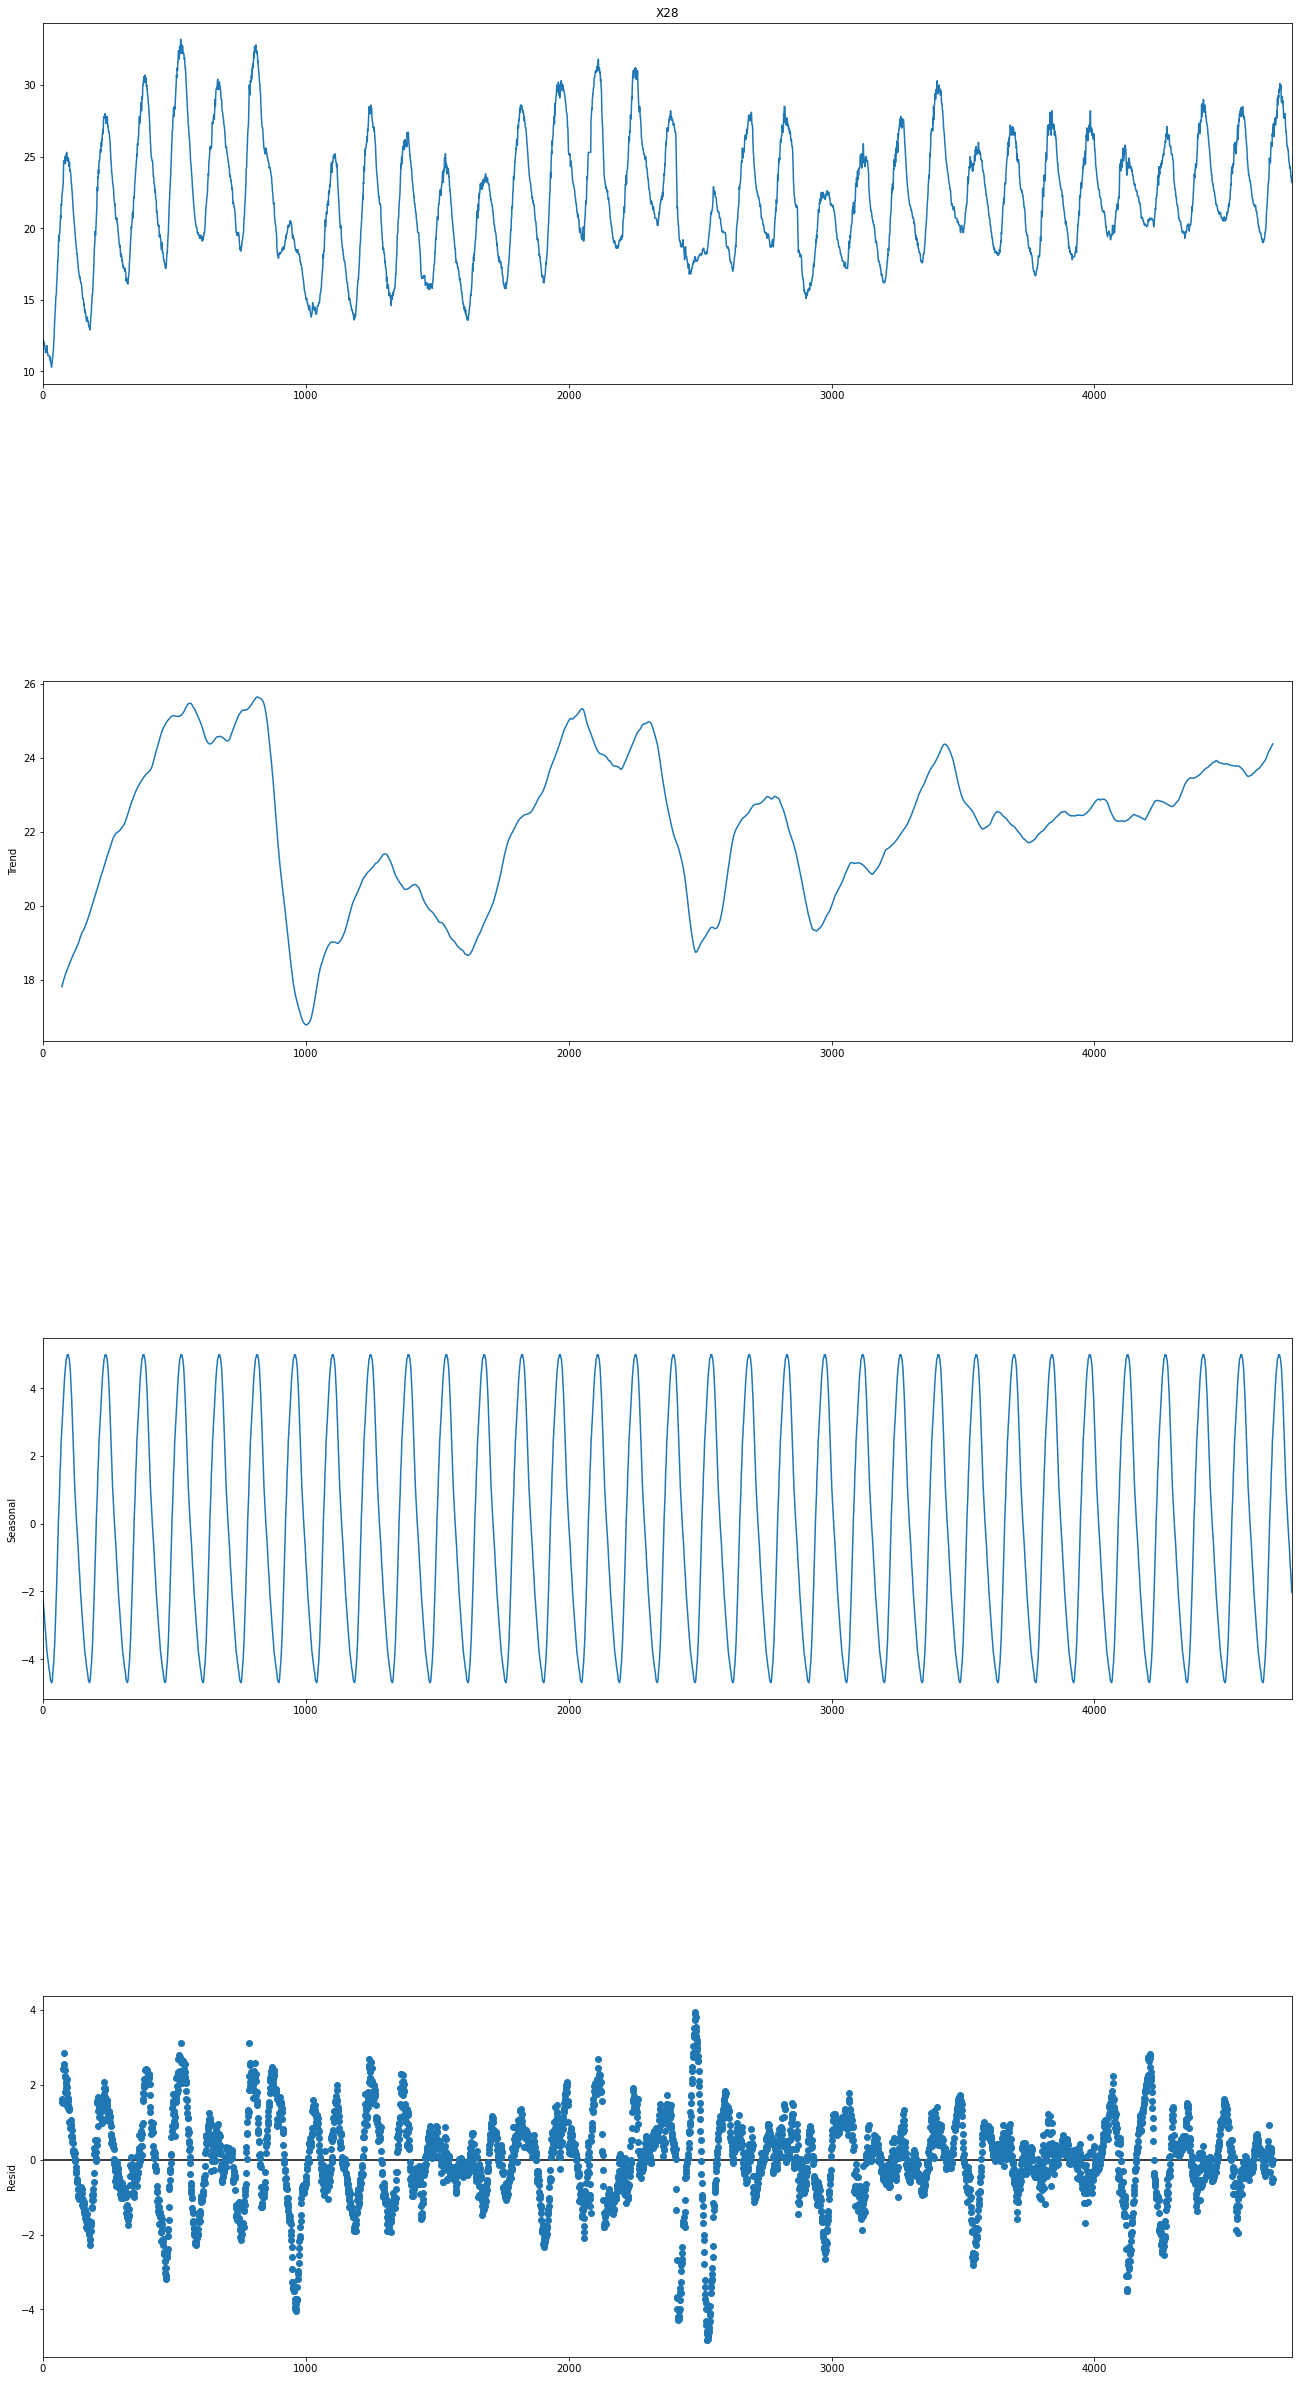

In [22]:
result = seasonal_decompose(train["X28"], model = 'addictive', freq = 144)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,40)

### <결론>
#### 습도    기온   	
#### X20(o) = X00(b)  			

#### X12(b) =  X31(r)  			
	
#### X37(r) = X07(o) 	 	

#### X30(g) = X32(p)  		

#### X38(p) = X28(g) 

### 2) Feature 추가 

-   일조량, 강수량 diff 
-   불쾌지수
-   체감온도
-   이슬점
-   포화수증기량
-   시간

## part5. Modeling & Model Tuning 

### Modeling

#### MLP 모델은 총 2개로 진행. 

##### 처음 33days에 대한 예측모델과 80days를 예측모델의  hidden layer갯수와 epoch, batch size를 다르게 적용하여 학습해야 한다고 판단하였기 때문.

-  Activation : Relu 사용 , 그 외 Gelu ,Elu 등 Relu의 확장된 함수들을 사용해 보았지만 성능이 그리 좋진 않았다.
-  optimazier: Adam , Rmsprob 의 조합.
-  loss : 대회의 평가방식인 mse
-  learning epoch, batchsize :계속 바꿔가며 성능 비교후 결정함 (80,16,16 / 80,16,8 / 200,14,16)
-  callback: earlystopping , ModelCheckPoint 으로 최적의 epoch와 batch일때의 모델로 예측한다.
-  random seed : 777(모두 동일하게 부여)
-  ensemble :최종모델에는 낮은 mae를 갖는(작을수록 실제값과 가깝다)모델 6개에 대한 평균
-  마지막 예측값들에 savol_filter를 씌어서 잡음 제거

In [23]:
#첫번째 모델 : 3일의 Y00-Y17 예측 , 30일의 Y18 예측

#train model 1
def build_model(train_data):
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu",
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation = "relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mse',metrics=['mae'])
    return model

earlystopper = EarlyStopping(monitor="loss", patience=30, mode="min", verbose=2) 
modelcheck_p = ModelCheckpoint("best_model", monitor="loss", mode="min", save_best_only=True) 

with tqdm(total=len(test_target.columns)) as pbar:
    for i in test_target.columns :
        random.seed(777)
        np.random.seed(777)
        tf.random.set_seed(777)
        model = build_model(train_data)  
        model.fit(train_data, train_target[i],  # train데이터로 훈련 
                     epochs=80, batch_size=16, verbose=2, callbacks=[earlystopper])  #80,16,16
        test_mse_score, test_mae_score = model.evaluate(test_data, test_target[i])

          # 마지막 노드 데이터 = 예측값을 가져와서 빈 데이터프레임에 합치기
        result = model.predict(test_data, batch_size=16)
        r = pd.DataFrame(result)
        r.columns = [i+'_pre']
        r_df = r_df.join(r)
        pbar.update(1)

In [24]:
#두번째 모델 : Y18 80일에 대한 예측 

#train model 2
def build_model(train_data):
    model = models.Sequential()
    model.add(layers.Dense(512, activation="relu", input_shape=(train_data.shape[1],))) 
    model.add(layers.Dense(256, activation = "relu")) 
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dense(64, activation = "relu"))
    model.add(layers.Dense(32, activation = "relu"))
    model.add(layers.Dense(16, activation = "relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
    return model 


model = build_model(train_data)
model.fit(train_data, train_target,
          epochs=400, batch_size=14, verbose=2, callbacks=[earlystopper,modelcheck_p]) #80,14,16
model=load_model("best_model") #새로 추가) best_model 로드
result = model.predict(test_data, batch_size=16)
r3 = pd.DataFrame(result)
r3.columns = ['Y18_pre']
df = df.join(r3)

## Part6. Conclusion 

##### 단순한 MLP 모형의 한계를 느낀 경험이었지만, 이것저것 실험하며 의미있는 프로젝트였습니다.   